In [2]:
import cv2
from IPython.display import Image, display
import numpy as np
import copy
import json
import os
import glob

In [4]:
WIN_USERNAME = "" # 隠蔽
SCREENSHOT_DIR = f"/mnt/c/Users/{WIN_USERNAME}/Pictures/Screenshots"
FILENAME = ""
if FILENAME != "":
    path = os.path.join(SCREENSHOT_DIR, FILENAME)
else:
    files = glob.glob(SCREENSHOT_DIR + "/スクリーンショット*")
    path = max(files, key=os.path.getctime) # latest changed file
    

In [5]:
def convert_nparr_to_image(img):
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))


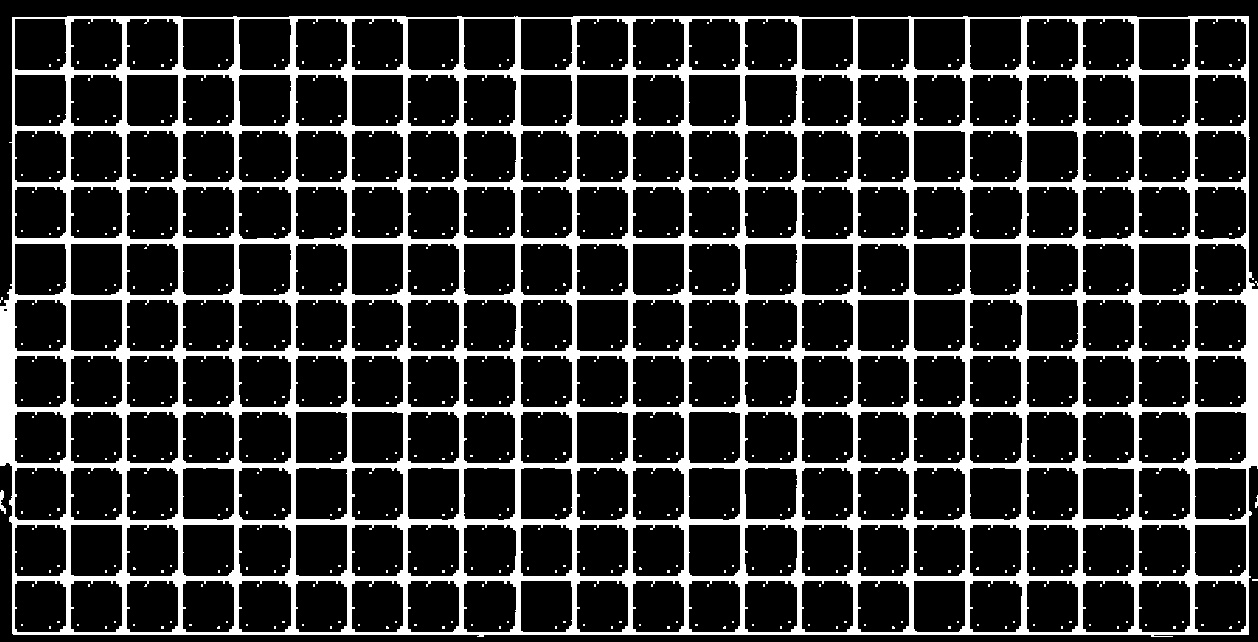

In [7]:
img = cv2.imread(path)
img_rev = cv2.bitwise_not(img)
lower_color = np.array([200, 200, 200])
upper_color = np.array([255, 255, 255]) 
img2 = cv2.inRange(img_rev, lower_color, upper_color)

# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
convert_nparr_to_image(img2)

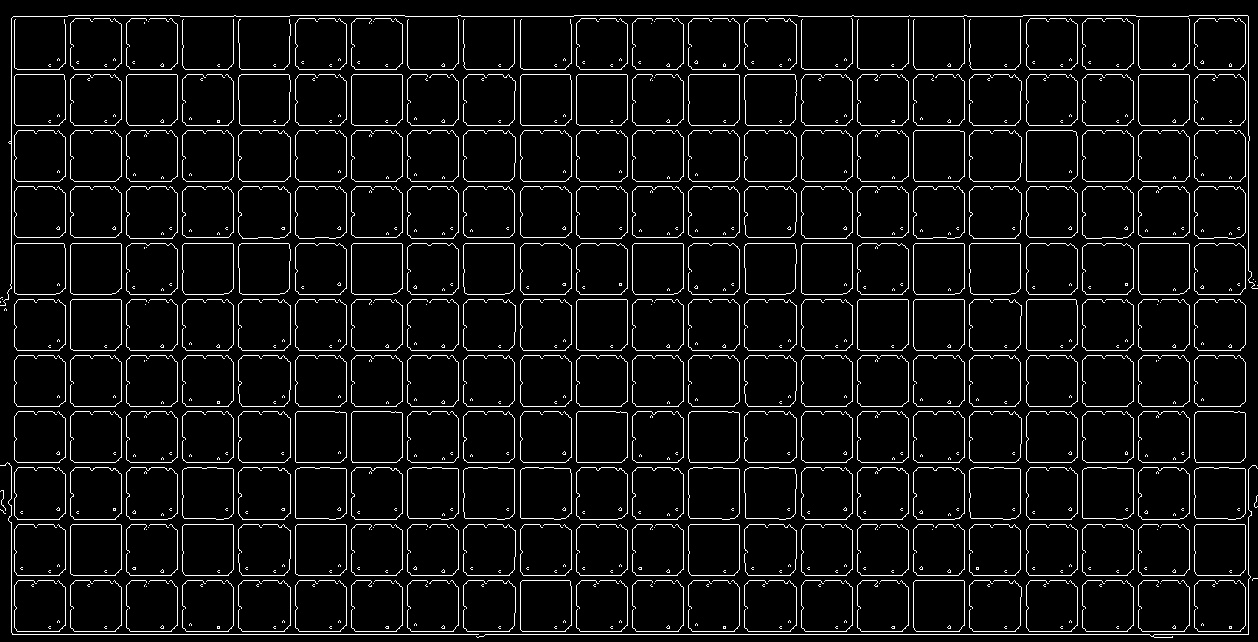

In [8]:
threshold1 = 400
threshold2 = 400
edges = cv2.Canny(img2, threshold1, threshold2)
convert_nparr_to_image(edges)

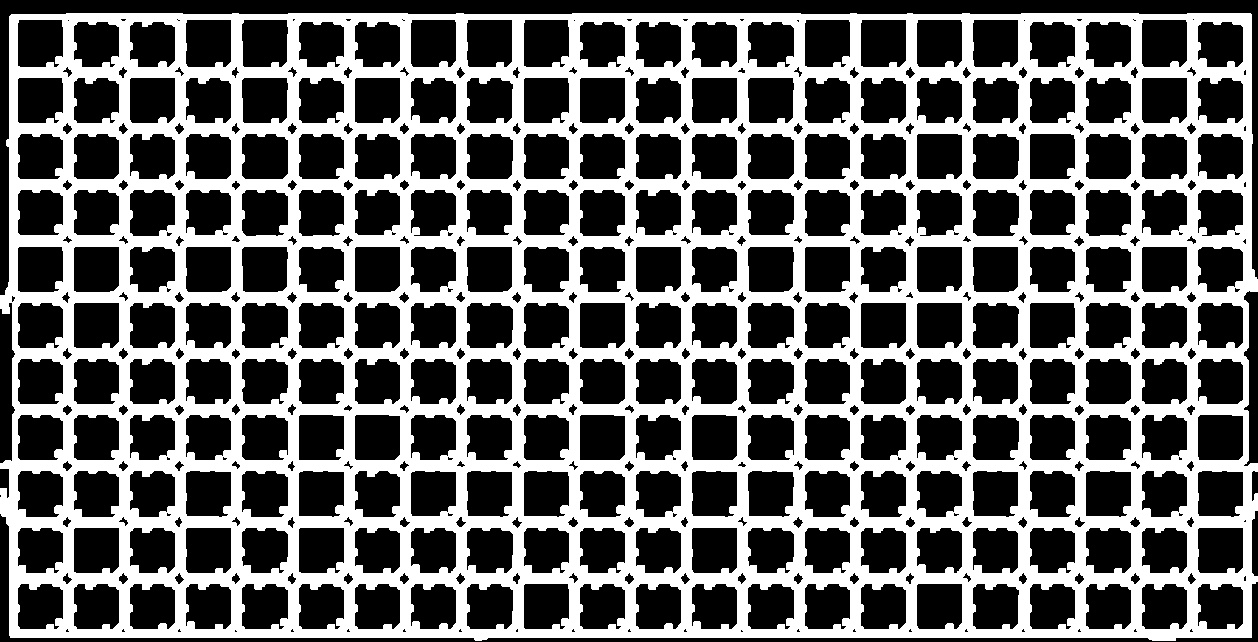

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
dilates = cv2.dilate(edges, kernel)
convert_nparr_to_image(dilates)

In [11]:
contours, hierarchy = cv2.findContours(dilates, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [12]:
from functools import cmp_to_key
def cmprect(l, r):
    EPS = 3
    if l[0][1] + EPS < r[0][1]: return -1
    if r[0][1] + EPS < l[0][1]: return 1
    if l[0][0] + EPS < r[0][0]: return -1
    if r[0][0] + EPS < l[0][0]: return 1

    return 0

In [13]:
rects = []
EPS = 3
for cnt, hrchy in zip(contours, hierarchy[0]):
    if cv2.contourArea(cnt) < 1000:
        continue  # 面積が小さいものは除く
    if cv2.contourArea(cnt) > 10000:
        continue
    if hrchy[3] == -1:
       continue  # ルートノードは除く
    # 輪郭を囲む長方形を計算する。
    rect = cv2.minAreaRect(cnt)
    rect_points = cv2.boxPoints(rect).astype(int)
    if abs(abs(rect_points[0][0] - rect_points[2][0]) - abs(rect_points[0][1] - rect_points[1][1])) > EPS:
        continue
        
    rects.append(rect_points)

# x-y 順でソート
rects = sorted(rects, key=cmp_to_key(cmprect))



# 描画する。
img3 = img.copy()
for i, rect in enumerate(rects):
    color = np.random.randint(254, 255, 3).tolist()
    cv2.drawContours(img3, rects, i, color, 2)
    cv2.putText(img3, str(i), tuple(rect[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
    
    print('rect:\n', rect)
print(len(rects))

# convert_nparr_to_image(img3)

rect:
 [[17 67]
 [17 19]
 [63 19]
 [63 67]]
rect:
 [[ 73  67]
 [ 73  21]
 [119  21]
 [119  67]]
rect:
 [[129  67]
 [129  21]
 [175  21]
 [175  67]]
rect:
 [[184  66]
 [184  18]
 [230  19]
 [230  66]]
rect:
 [[241  67]
 [241  19]
 [288  19]
 [288  67]]
rect:
 [[298  67]
 [298  21]
 [344  21]
 [344  67]]
rect:
 [[354  67]
 [354  21]
 [400  21]
 [400  67]]
rect:
 [[410  67]
 [410  19]
 [456  19]
 [456  67]]
rect:
 [[466  66]
 [466  18]
 [512  19]
 [512  66]]
rect:
 [[523  67]
 [523  19]
 [569  19]
 [569  67]]
rect:
 [[579  67]
 [579  21]
 [625  21]
 [625  67]]
rect:
 [[635  67]
 [635  21]
 [681  21]
 [681  67]]
rect:
 [[691  67]
 [691  21]
 [737  21]
 [737  67]]
rect:
 [[747  67]
 [747  21]
 [794  21]
 [794  67]]
rect:
 [[804  67]
 [804  19]
 [850  19]
 [850  67]]
rect:
 [[860  67]
 [860  19]
 [906  19]
 [906  67]]
rect:
 [[916  67]
 [916  19]
 [962  19]
 [962  67]]
rect:
 [[ 972   66]
 [ 972   18]
 [1018   19]
 [1018   66]]
rect:
 [[1029   67]
 [1029   21]
 [1075   21]
 [1075   67]]
rect

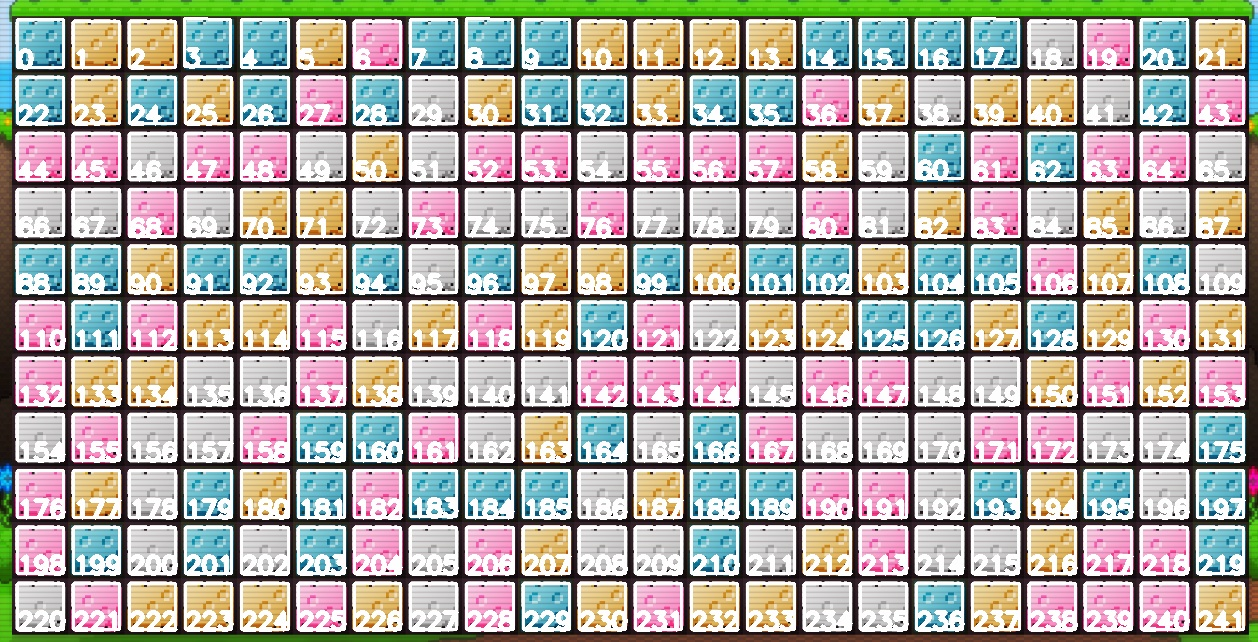

In [14]:
convert_nparr_to_image(img3)

In [15]:
def find_color(bgr):
    EPS = 30
    targets = np.array([[210, 210, 211], [209, 165, 251], [116, 195, 231], [206, 189, 99]])
    for i, target in enumerate(targets):
        if np.bitwise_and(target - EPS <= bgr, bgr <= target + EPS).all():
            return i+1
    return 0

colors = []

for i, rect in enumerate(rects):
    rect_avg = np.average(rect, axis=0)
    rect_avg = np.floor(rect_avg).astype(int)
    # print(rect_avg)
    bgr = img[rect_avg[1], rect_avg[0], :]
    color = find_color(bgr)
    colors.append(color)
    # print(f"rect[{i}]: {find_color(bgr)}")
print("zeros:", (np.array(colors) == 0).sum())
colors[0:10]

zeros: 0


[4, 3, 3, 4, 4, 3, 2, 4, 4, 4]

In [16]:
a = np.array(colors)
a = a.reshape((11, 22))
print(a)
np.savetxt("./colors.csv", a, delimiter=",", fmt="%d")

[[4 3 3 4 4 3 2 4 4 4 3 3 3 3 4 4 4 4 1 2 4 3]
 [4 3 4 3 4 2 4 1 3 4 4 3 4 4 2 3 1 3 3 1 4 2]
 [2 2 1 2 2 1 3 1 2 2 1 2 2 2 3 1 4 2 4 2 2 1]
 [1 1 2 1 3 3 1 2 1 1 2 1 1 1 2 1 3 2 1 3 1 3]
 [4 4 3 4 4 3 4 1 4 3 3 4 3 4 4 3 4 4 2 3 4 1]
 [2 4 2 3 3 2 1 3 2 3 4 2 1 3 3 4 4 3 4 3 2 3]
 [2 3 3 1 1 2 3 1 1 1 2 2 2 1 2 2 1 1 3 2 3 2]
 [1 2 1 1 2 4 4 2 1 3 4 1 4 2 1 1 1 2 2 1 1 4]
 [2 3 1 4 3 4 2 4 4 4 1 3 4 4 2 2 1 4 3 4 1 4]
 [2 4 1 4 1 4 2 1 2 3 1 1 4 1 3 2 1 1 3 2 2 4]
 [1 2 3 3 3 2 3 1 2 4 3 2 3 3 1 1 4 3 2 2 2 3]]
